https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import xgboost as xgb
from matplotlib import pyplot as plt

train = pd.read_csv('train.csv', index_col='Id')
submit = pd.read_csv('test.csv', index_col='Id')

# Оцениваем обстановку

In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

Тут видим, что 
- 5   Alley
- 56  FireplaceQu
- 71  PoolQC
- 72  Fence
- 73  MiscFeature

Больше чем на полловину или даже на все 90% состоят из пропущенных данных

Выборка для отправки не сильно отличается (по пропущенным данным) от обучающей

Много данных типа object


In [3]:
submit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 1461 to 2919
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1455 non-null   object 
 2   LotFrontage    1232 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   object 
 5   Alley          107 non-null    object 
 6   LotShape       1459 non-null   object 
 7   LandContour    1459 non-null   object 
 8   Utilities      1457 non-null   object 
 9   LotConfig      1459 non-null   object 
 10  LandSlope      1459 non-null   object 
 11  Neighborhood   1459 non-null   object 
 12  Condition1     1459 non-null   object 
 13  Condition2     1459 non-null   object 
 14  BldgType       1459 non-null   object 
 15  HouseStyle     1459 non-null   object 
 16  OverallQual    1459 non-null   int64  
 17  OverallCond    1459 non-null   int64  
 18  YearB

# Baseline model

Атакуем в лоб



## LabelEncoder

C:\Users\kuzmi\AppData\Local\Temp/ipykernel_11196/2750071516.py:6: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  non_num_feature  = [key for key, val in train.dtypes.to_dict().items() if val == np.object]


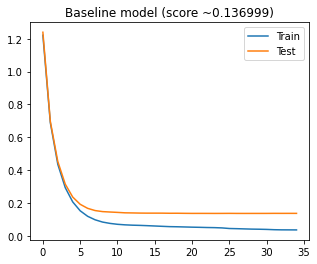

In [36]:
from sklearn.preprocessing import LabelEncoder

X_train, X_test, y_train, y_test = train_test_split(train.iloc()[:, :-1], train['SalePrice'], random_state=0)

# отпределяем нечисловые поля и кодируем их числами
non_num_feature  = [key for key, val in train.dtypes.to_dict().items() if val == np.object]
encoders = [(feature, LabelEncoder().fit(train[feature])) for feature in non_num_feature]
for feature, enc in encoders:
  X_train[feature] = enc.transform(X_train[feature])
  X_test[feature] = enc.transform(X_test[feature])

# обучаем модель
baseline_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=35, learning_rate=0.3)
eval_set = [(X_train, y_train), (X_test, y_test)]
baseline_model.fit(X_train, y_train, eval_metric=["rmsle"], eval_set=eval_set, verbose=False)

# получаем значения метрики
results = baseline_model.evals_result()
epochs = len(results['validation_0']['rmsle'])
x_axis = range(epochs)

# рисуем
fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
ax1.plot(x_axis, results['validation_0']['rmsle'], label='Train')
ax1.plot(x_axis, results['validation_1']['rmsle'], label='Test')
ax1.legend()
ax1.set_title(f'Baseline model (score ~{results["validation_1"]["rmsle"][-1]})');

## OneHotEncoder

Кодируем OneHotEncoder'ом

C:\Users\kuzmi\AppData\Local\Temp/ipykernel_11196/1589536489.py:5: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  non_num_features  = [key for key, val in train.dtypes.to_dict().items() if val == np.object]


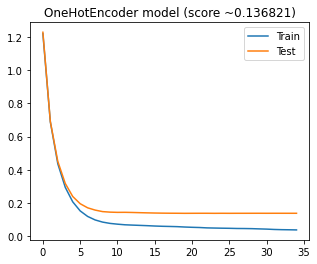

In [ ]:
from sklearn.preprocessing import OneHotEncoder

X_train, X_test, y_train, y_test = train_test_split(train.iloc()[:,:-1], train['SalePrice'], random_state=0)

non_num_features  = [key for key, val in train.dtypes.to_dict().items() if val == np.object]

enc = OneHotEncoder().fit(train[non_num_features])

ohe_X_train = pd.DataFrame(enc.transform(X_train[non_num_features]).toarray(), columns=enc.get_feature_names(non_num_features))
ohe_X_train['Id'] = X_train.index
ohe_X_train.set_index('Id', inplace=True)
X_train = pd.concat([X_train, ohe_X_train], axis=1).drop(non_num_features, axis=1)

ohe_X_test = pd.DataFrame(enc.transform(X_test[non_num_features]).toarray(), columns=enc.get_feature_names(non_num_features))
ohe_X_test['Id'] = X_test.index
ohe_X_test.set_index('Id', inplace=True)
X_test = pd.concat([X_test, ohe_X_test], axis=1).drop(non_num_features, axis=1)

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=35, learning_rate=0.3, )
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["rmsle"], eval_set=eval_set, verbose=False)

results = model.evals_result()
epochs = len(results['validation_0']['rmsle'])
x_axis = range(epochs)

fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
ax1.plot(x_axis, results['validation_0']['rmsle'], label='Train')
ax1.plot(x_axis, results['validation_1']['rmsle'], label='Test')
ax1.legend()
ax1.set_title(f'OneHotEncoder model (score ~{results["validation_1"]["rmsle"][-1]})');

# Feature Importances

На осовании базовой модели смотрим на важность признаков при работе с тестовой выборкой. Двумя способами.

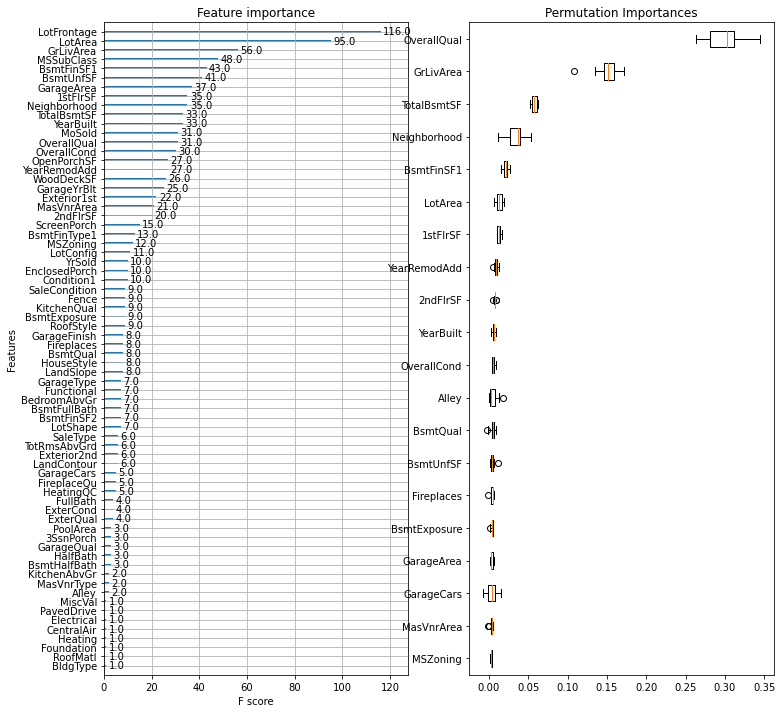

In [5]:
from sklearn.inspection import permutation_importance

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))

# при помощи встроенной в xgb функции
xgb.plot_importance(baseline_model, ax=ax1)

# перестановками
result = permutation_importance(
    baseline_model, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1
)
sorted_idx = result.importances_mean.argsort()
ax2.boxplot(result.importances[sorted_idx][-20:].T, vert=False, labels=X_test.columns[sorted_idx][-20:])
ax2.set_title("Permutation Importances")
plt.show()

# Feature Importances model
Строим модель, которая включает только 20 самых "важных" признака

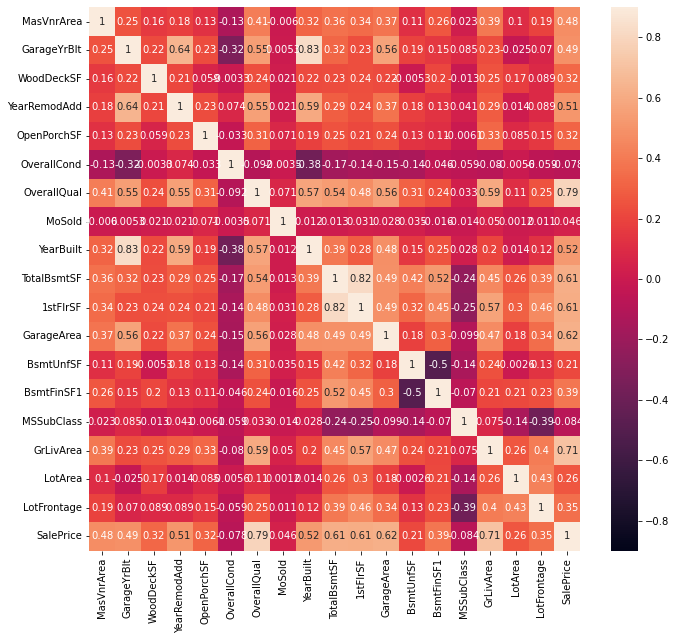

In [6]:
features = list(map(lambda x: x.get_text(), list(ax1.get_yticklabels())[-20:]))

# матрица межфакторной корреляции
fig, ax1 = plt.subplots(1, 1, figsize=(11, 10))
sns.heatmap(train[features+['SalePrice']].corr(), annot = True, vmin=-0.9, vmax=0.9, ax=ax1)

# убираем парочку признаков, чтобы убрать мультиколениарность
features.remove('GarageYrBlt')
features.remove('1stFlrSF')

Среди этой двадцатки оказалось два нечиловых признака Exterior1st и Neighborhood.

C:\Users\kuzmi\AppData\Local\Temp/ipykernel_11196/1665612145.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  f'{[key for key, val in train[features].dtypes.to_dict().items() if val == np.object]}')


Feature with dtype object in selected top 20: ['Exterior1st', 'Neighborhood']


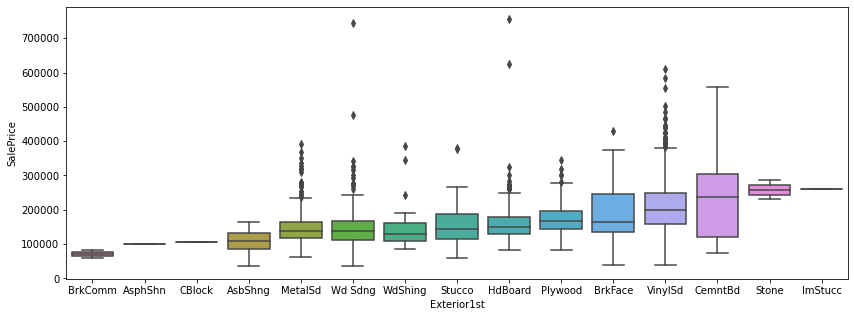

In [7]:
print(f'Feature with dtype object in selected top 20: '
f'{[key for key, val in train[features].dtypes.to_dict().items() if val == np.object]}')

# рисуем графики распределения для значений переменной Exterior1st
plt.figure(figsize=(14,5))
order = train.groupby('Exterior1st').mean()['SalePrice'].sort_values().index
sns.boxplot(data=train, x='Exterior1st', y='SalePrice', order=order)
plt.show()

Тут можно заметить некоторую схожесть распределений меджду рядом значений (в чем можно убетиться посчитав p-value), поэтому их можно объеденить в группы.

In [8]:
from scipy.stats import f_oneway

fvalue, pvalue = f_oneway(*[train[train['Exterior1st'] == label]['SalePrice'] for label in ['MetalSd', 'WdShing', 'Wd Sdng']])
print(f"P-value {pvalue} for group ['MetalSd', 'WdShing', 'Wd Sdng']")

P-value 0.9945163948798683 for group ['MetalSd', 'WdShing', 'Wd Sdng']


Дальше можно было бы замеить эти и другие схожие значения на группы (примерно как показвно ниже), но мне стало лень заниматься этим, особенно когда увидел график распределений для втого признака Neighborhood. А потонцильно дальше опять придется этим заматься...

In [9]:
# train_new['Exterior1st'].replace(['MetalSd', 'WdShing', 'Wd Sdng'],'Exterior1st_1',inplace=True)
# train_new['Exterior1st'].replace(['CemntBd','ImStucc','Stone'],'Exterior1st_2',inplace=True)
# train_new['Exterior1st'].replace(['AsbShng','CBlock', 'AsphShn'],'Exterior1st_3',inplace=True)
# train_new['Exterior1st'].replace(['HdBoard', 'Stucco'],'Exterior1st_4',inplace=True)
# train_new['Exterior1st'].replace(['VinylSd', 'HdBoard', 'BrkFace', 'Plywood', 'Stucco', 'BrkComm'],'Other',inplace=True)

## class KlasterLabelEncoder()

Поэтому я решил автоматезировать этот процесс следующим образом. Я составляю матрицу значений p-value между всеми значениями признака, затем кластеризую наиболее близкие признаки в группы. Методику кластеризации я подсмотрел [тут](https://github.com/kuzminRM/My_ML_Notes/blob/main/extensions/Multicollinear_Clustering.ipynb).

Собственно, класс KlasterLabelEncoder какраз всем этим и занимается

In [10]:
from scipy.cluster import hierarchy
from scipy.stats import f_oneway
from scipy.spatial.distance import squareform
from collections import defaultdict

class KlasterLabelEncoder():

  def fit(self, df: pd.DataFrame, feature):
    self.group_values(df, feature)
    return self

  def transform(self, df: pd.DataFrame, feature):    
    for k, v in self.cluster_id_to_feature_ids.items():
      df[feature].replace(self.u[v], k, inplace=True)

  def fit_transform(self, df: pd.DataFrame, feature):
    self.fit(df, feature)
    self.transform(df, feature)
    return self

  def group_values(self, df: pd.DataFrame, feature: str):
    """Группирует (кластеризует) значения фактора по значениям матрицы p-value
    и заменяет значения в переданном DataFrame на номера клстеров"""
    corr = self.get_pvalue_matrix(df, feature)

    # NaN появляются если значение встречается слишком мало раз
    corr = np.nan_to_num(corr, nan=0.) # можно еще попробовать передать nan=1.
    corr = (corr + corr.T) / 2
    np.fill_diagonal(corr, 1)

    distance_matrix = 1 - np.abs(corr)

    dist_linkage = hierarchy.ward(squareform(distance_matrix))

    cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")

    self.cluster_id_to_feature_ids = defaultdict(list)
    for idx, cluster_id in enumerate(cluster_ids):
      self.cluster_id_to_feature_ids[cluster_id].append(idx)

    self.u = df[feature].unique()

  @staticmethod
  def get_pvalue(df: pd.DataFrame, feature: str, labels: list):
    """Возвразает значение p-value для перданного списка labels"""
    fvalue, pvalue = f_oneway(*[df[df[feature] == label]['SalePrice'] for label in labels])
    return pvalue

  @staticmethod
  def get_pvalue_matrix(df: pd.DataFrame, feature: str):
    """Возвразает матрицу p-value для перданного фактора"""
    labels = df[feature].unique()
    matrix = []
    for y in labels:
      matrix.append([])
      for x in labels:
        matrix[-1].append(KlasterLabelEncoder.get_pvalue(df, feature, [x, y]))
    return  np.array(matrix)

В итоге преобразование запишется так:

In [11]:
X_train, X_test, y_train, y_test = train_test_split(train[features], train['SalePrice'], random_state=0)

Neighborhood_enc = KlasterLabelEncoder().fit(train, 'Neighborhood')
Neighborhood_enc.transform(X_train, 'Neighborhood')
Neighborhood_enc.transform(X_test, 'Neighborhood')

Exterior1st_enc = KlasterLabelEncoder().fit(train, 'Exterior1st')
Exterior1st_enc.transform(X_train, 'Exterior1st')
Exterior1st_enc.transform(X_test, 'Exterior1st')

C:\Users\kuzmi\anaconda3\lib\site-packages\scipy\stats\stats.py:3629: F_onewayBadInputSizesWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  warnings.warn(F_onewayBadInputSizesWarning(msg))


Можно заметить, что алгоритм кластеризовал значения признака Exterior1st примерно также как и я:

In [12]:
u = Exterior1st_enc.u
for k, v in Exterior1st_enc.cluster_id_to_feature_ids.items():
  print(f'Кластер {k}, {[u[i] for i in v]}')

# как сделал я:
# train_new['Exterior1st'].replace(['MetalSd', 'WdShing', 'Wd Sdng'],'Exterior1st_1',inplace=True)
# train_new['Exterior1st'].replace(['CemntBd','ImStucc','Stone'],'Exterior1st_2',inplace=True)
# train_new['Exterior1st'].replace(['AsbShng','CBlock', 'AsphShn'],'Exterior1st_3',inplace=True)
# train_new['Exterior1st'].replace(['HdBoard', 'Stucco'],'Exterior1st_4',inplace=True)
# train_new['Exterior1st'].replace(['VinylSd', 'HdBoard', 'BrkFace', 'Plywood', 'Stucco', 'BrkComm'],'Other',inplace=True)

Кластер 1, ['VinylSd', 'CemntBd', 'Stone', 'ImStucc']
Кластер 2, ['MetalSd', 'Wd Sdng', 'WdShing']
Кластер 3, ['HdBoard', 'Plywood', 'Stucco']
Кластер 4, ['BrkFace', 'AsbShng', 'BrkComm', 'AsphShn', 'CBlock']


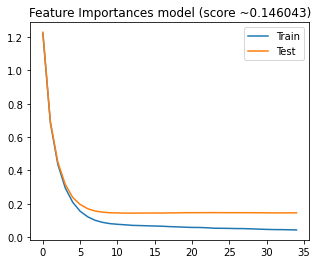

In [13]:
# смотрим что получилось (получилось плохо)
model_new = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=35, learning_rate=0.3, )
eval_set = [(X_train, y_train), (X_test, y_test)]
model_new.fit(X_train, y_train, eval_metric=["rmsle"], eval_set=eval_set, verbose=False)

results = model_new.evals_result()
epochs = len(results['validation_0']['rmsle'])
x_axis = range(epochs)

fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
ax1.plot(x_axis, results['validation_0']['rmsle'], label='Train')
ax1.plot(x_axis, results['validation_1']['rmsle'], label='Test')
ax1.legend()
ax1.set_title(f'Feature Importances model (score ~{results["validation_1"]["rmsle"][-1]})');

# KlasterLabelEncoder model

C:\Users\kuzmi\anaconda3\lib\site-packages\scipy\stats\stats.py:3621: F_onewayBadInputSizesWarning: at least one input has length 0
  warnings.warn(F_onewayBadInputSizesWarning('at least one input '
C:\Users\kuzmi\anaconda3\lib\site-packages\scipy\stats\stats.py:3629: F_onewayBadInputSizesWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  warnings.warn(F_onewayBadInputSizesWarning(msg))


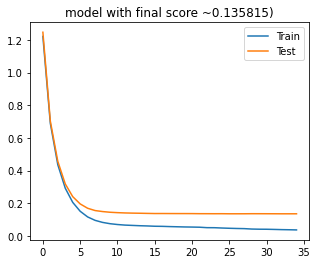

In [17]:
encoders = [(feature, KlasterLabelEncoder().fit(train, feature)) for feature in non_num_features]

X_train, X_test, y_train, y_test = train_test_split(train.iloc()[:,:-1], train['SalePrice'], random_state=0)

for feature, enc in encoders:
  enc.transform(X_train, feature)
  enc.transform(X_test, feature)

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=35, learning_rate=0.3, )

eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["rmsle"], eval_set=eval_set, verbose=False)

results = model.evals_result()
epochs = len(results['validation_0']['rmsle'])
x_axis = range(epochs)

fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
ax1.plot(x_axis, results['validation_0']['rmsle'], label='Train')
ax1.plot(x_axis, results['validation_1']['rmsle'], label='Test')
ax1.legend()
ax1.set_title(f'KlasterLabelEncoder model (score ~{results["validation_1"]["rmsle"][-1]})');

## KlasterLabelEncoder + OneHotEncoder

C:\Users\kuzmi\anaconda3\lib\site-packages\scipy\stats\stats.py:3621: F_onewayBadInputSizesWarning: at least one input has length 0
  warnings.warn(F_onewayBadInputSizesWarning('at least one input '
C:\Users\kuzmi\anaconda3\lib\site-packages\scipy\stats\stats.py:3629: F_onewayBadInputSizesWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  warnings.warn(F_onewayBadInputSizesWarning(msg))


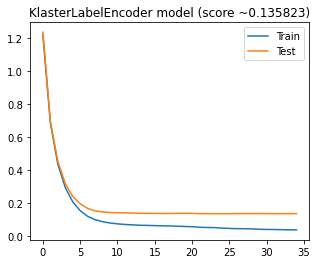

In [95]:
encoders = [(feature, KlasterLabelEncoder().fit(train, feature)) for feature in non_num_features]

X_train, X_test, y_train, y_test = train_test_split(train.iloc()[:,:-1], train['SalePrice'], random_state=0)

for feature, enc in encoders:
  enc.transform(X_train, feature)
  enc.transform(X_test, feature)

enc = OneHotEncoder().fit(X_train[non_num_features])

ohe_X_train = pd.DataFrame(enc.transform(X_train[non_num_features]).toarray(), columns=enc.get_feature_names(non_num_features))
ohe_X_train['Id'] = X_train.index
ohe_X_train.set_index('Id', inplace=True)
X_train = pd.concat([X_train, ohe_X_train], axis=1).drop(non_num_features, axis=1)

ohe_X_test = pd.DataFrame(enc.transform(X_test[non_num_features]).toarray(), columns=enc.get_feature_names(non_num_features))
ohe_X_test['Id'] = X_test.index
ohe_X_test.set_index('Id', inplace=True)
X_test = pd.concat([X_test, ohe_X_test], axis=1).drop(non_num_features, axis=1)

model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=35, learning_rate=0.3)

eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["rmsle"], eval_set=eval_set, verbose=False)

results = model.evals_result()
epochs = len(results['validation_0']['rmsle'])
x_axis = range(epochs)

fig, ax1 = plt.subplots(1, 1, figsize=(5, 4))
ax1.plot(x_axis, results['validation_0']['rmsle'], label='Train')
ax1.plot(x_axis, results['validation_1']['rmsle'], label='Test')
ax1.legend()
ax1.set_title(f'KlasterLabelEncoder model (score ~{results["validation_1"]["rmsle"][-1]})');

## GridSearchCV

Последний вариант показал лучшие результаты, и имеет больший потенциал, поэтому используем его

In [100]:
from sklearn.model_selection import GridSearchCV

train_copy = train.copy()

for feature, enc in encoders:
  enc.transform(train_copy, feature)

# много раз менялось, тут последняя попытка (не самая лучшая на kagle)
parameters = {
              'max_depth': (4, 5, 6),
              'reg_alpha': (np.linspace(0.4, 0.7, num=4)),
              'reg_lambda': (np.linspace(0.7, 1, num=4)),
              'subsample': (0.4, 0.5, 0.65),
              'colsample_bytree': (0.4, 0.5, 0.65),
              }

model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=0.01, n_estimators=1500)

gr_ser = GridSearchCV(estimator=model,
                      param_grid=parameters,
                      scoring='neg_mean_squared_log_error',
                      verbose=2,
                      n_jobs=-1)
gr_ser.fit(train_copy.iloc()[:,:-1], train_copy['SalePrice'])
pd.DataFrame(gr_ser.cv_results_).sort_values('rank_test_score').head(15)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_max_depth,param_reg_alpha,param_reg_lambda,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
317,8.907104,0.206131,0.010001,0.001096,0.65,4,0.6,0.8,0.65,"{'colsample_bytree': 0.65, 'max_depth': 4, 're...",-0.011637,-0.018400,-0.016264,-0.012316,-0.015582,-0.014840,0.002525,1
329,8.678841,0.214746,0.010002,0.000633,0.65,4,0.7,0.8,0.65,"{'colsample_bytree': 0.65, 'max_depth': 4, 're...",-0.011637,-0.018400,-0.016264,-0.012316,-0.015582,-0.014840,0.002525,2
293,8.792094,0.325978,0.010402,0.001020,0.65,4,0.4,0.8,0.65,"{'colsample_bytree': 0.65, 'max_depth': 4, 're...",-0.011608,-0.018400,-0.016264,-0.012316,-0.015637,-0.014845,0.002536,3
43,7.033984,0.234485,0.011403,0.001020,0.4,4,0.7,0.9,0.5,"{'colsample_bytree': 0.4, 'max_depth': 4, 'reg...",-0.011516,-0.018932,-0.015646,-0.012524,-0.015631,-0.014850,0.002624,4
305,9.202880,0.040117,0.010802,0.001166,0.65,4,0.5,0.8,0.65,"{'colsample_bytree': 0.65, 'max_depth': 4, 're...",-0.011637,-0.018400,-0.016264,-0.012317,-0.015637,-0.014851,0.002528,5
31,6.665124,0.305793,0.015625,0.000001,0.4,4,0.6,0.9,0.5,"{'colsample_bytree': 0.4, 'max_depth': 4, 'reg...",-0.011516,-0.018955,-0.015646,-0.012524,-0.015631,-0.014854,0.002631,6
7,6.930667,0.185004,0.013604,0.005084,0.4,4,0.4,0.9,0.5,"{'colsample_bytree': 0.4, 'max_depth': 4, 'reg...",-0.011516,-0.018955,-0.015646,-0.012524,-0.015631,-0.014854,0.002631,7
19,6.865095,0.232160,0.010403,0.001744,0.4,4,0.5,0.9,0.5,"{'colsample_bytree': 0.4, 'max_depth': 4, 'reg...",-0.011516,-0.018955,-0.015646,-0.012524,-0.015631,-0.014854,0.002631,8
38,6.749945,0.227793,0.011202,0.001327,0.4,4,0.7,0.7,0.65,"{'colsample_bytree': 0.4, 'max_depth': 4, 'reg...",-0.011472,-0.018863,-0.016030,-0.012444,-0.015561,-0.014874,0.002653,9
26,6.591003,0.333150,0.006251,0.007655,0.4,4,0.6,0.7,0.65,"{'colsample_bytree': 0.4, 'max_depth': 4, 'reg...",-0.011472,-0.018863,-0.016030,-0.012444,-0.015561,-0.014874,0.002653,10


In [101]:
submit_copy = submit.copy()

for feature, enc in encoders:
  enc.transform(submit_copy, feature)

submit_copy['SalePrice'] = gr_ser.best_estimator_.predict(submit_copy)
submit_copy['SalePrice'].to_csv('submit3.csv')

# Осталось без внимания

Эти манипуляции пойдут на пользу при выборе другой метрики (без логорифмов) и в случае когда у нас не kagle сревноавние)

In [23]:
# заполнение пропусков повышает ошибку
# null_columns = train_final.columns[train_final.isnull().sum() != 0]
# train_final[null_columns] = train_final[null_columns].fillna(0.)

# если убрать мультиколениарность ошибка тоже повысится
# num_feature_final  = [key for key, val in train.dtypes.to_dict().items() if val != np.object]
# num_feature_final.remove('GarageArea')
# num_feature_final.remove('TotalBsmtSF')
# num_feature_final.remove('TotRmsAbvGrd')

# выбор численных признаков которые имеют коэффициент корреляции в результирующим признаком > 0.3 - тоже
# num_feature_final = [k for k, v in train_final[num_feature_final].corr()['SalePrice'].to_dict().items() if abs(v)>0.3]
# num_feature_final.remove('SalePrice')